# Tutorial: Sensitivity Analysis of the HYMOD Model

This tutorial has been developed to showcase some of the sensitivity analysis and uncertainty quantification concepts and tools established in the main text in the context of HYMOD, a rainfall-runoff model. The tutorial includes the following sections:

#### Introduction to HYMOD and Sensitivity Analysis
[1- Introduction to a simple hydrologic model (HYMOD)](#hymod) <br>
[2- An overview of sensitivity analysis using SALib](#sensitivity)  <br>
[3- Calculation of sensitivity analysis metrics](sa_metrics)  <br>

#### Time-Varying Sensitivity Analysis
[4- Time-varying sensitivity analysis](#TVSA)  <br>

#### Ensemble-based Parametric Uncertainty
[5- Generalized Likelihood Uncertainty Estimation (GLUE)](#GLUE)  <br>
[6- Pre-Calibration](#precalibration) <br>

<b> It is important to note that, </b> although in this tutorial we focus on HYMOD, which is a hydrologic model, it can also be thought of as an example of a model that abstracts complex non-linear systems. Therefore, many of the methods that we use in the tutorial can be applied to numerical models that simulate other complex non-linear systems.

# Introduction to HYMOD and Sensitivity Analysis

<a id='hymod'></a> 
# 1- HYMOD 

HYMOD is a simple hydrologic model (rainfall-runoff model) that simulates key hydrologic fluxes such as infiltration, streamflow and evapotranspiration. The model has been originally developed and used for river flow forecasting. However, in the last two decades the model has been widely used to explore different sensitivity analysis (e.g., [Herman et al., 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20124)), uncertainty quantification (e.g.,  [Smith et al., 2008](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005205)), and optimization (e.g., [Ye et al., 2014](https://www.sciencedirect.com/science/article/pii/S0022169414006362?casa_token=IRqE19Hkfa8AAAAA:_fXOqfwpzxMpchvu8_0njCe0Ok9H29Gyw2F46l9PzG9UVODDTUg6wIOSiyp6uybGevNVnZ7N)) concepts.

There are two main assumptions in the model: <br>
1) Rainfall is generated through infiltration excess overland flow. <br>
2) Runoff generation can be formulated by the probability-distributed principle (Moore, 1985). Therefore the cumulative rate storage capacity $(F(C))$ can be calculated using the following relationship:

$$F(C) = 1 - (1 - \frac{C}{C_{MAX}})^{B_{exp}}$$

where *$C$* is the water storage capacity; **$C_{MAX}$** is the parameter describing basin maximum water storage capacity (mm); and **$B_{exp}$** is the parameter describing the degree of spatial variability within the basin. 


The portion of precipitation that exceeds the water storage capacity is treated as runoff. The evapotranspiration is equal to potential evapotranspiration ($PET$) if enough water is available. Otherwise, it equals the available water storage.

Then, based on a parameter $Alpha$, the runoff is divided into quick flow and slow flow, which are routed through three identical quick flow tanks $Q1, Q2, Q3$ and a parallel slow flow tank, respectively.

The flow rates in the routing system are described by the resident time in the quick tanks $K_q$ (day) and the slow tank $K_s$ (day), respectively.

![alt text](./figs/hymod_schematic.png "Title")

Vrugt et al., (2008)


### 1-1 Model Parameters
$C_{MAX}$: parameters describing basin maximum water storage capacity (mm)

$B_{exp}$:      parameters describing the degree of spatial variability within the basin between 0 and Huz

$Alp$:    Fraction of runoff contributing to quick flow 

$K_q$:     Quick flow residence time of linear infinite reservoir (the Kq values of all three linear reservoirs are the same)

$K_s$:      Slow flow residence time of linear infinite reservoir


### 1-2 Input data

The HYMOD model only requires precipitation and potential evapotranspiration as inputs. The Leaf River example that we use here is also a widely used test case of HYMOD. The dataset also includes observed runoff that we later use to evaluate the performace of each sensitvity analysis sample set. 

We can use the following to read the input file:

In [1]:
import msdbook

import os
import math

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from matplotlib import pyplot as plt


In [2]:
# load the HYMOD input file
leaf_data = msdbook.load_hymod_input_file()

# extract the first eleven years of data
leaf_data = leaf_data.iloc[0:4015].copy()
 

In [3]:
# There are only three columns in the file including precipitation, potential evapotranspiration and  streamflow
leaf_data.head()

,Precip,Pot_ET,Strmflw
0,0.0,4.60,0.29
1,0.0,4.31,0.24
2,0.0,4.33,0.21
3,0.0,4.78,0.19
4,0.0,2.91,0.18


### 1-3 Baseline Model Simulation

We can start our sensitivity analysis experiment with running HYMOD using its default parameters.


In [4]:
# assign input parameters to generate a baseline simulated streamflow
Nq = 3  # Number of quickflow routing tanks 
Kq = 0.5 # Quickflow routing tanks' rate parameter    
Ks =  0.001 # Slowflow routing tank's rate parameter           
Alp = 0.5 # Quick/slow split parameter   
Huz = 100 # Maximum height of soil moisture accounting tank  
B = 1.0 # Scaled distribution function shape parameter    

# Note that the number of years is 11 years. One year of model warm-up and ten years are used for actual simulation
model = msdbook.hymod(Nq, Kq, Ks, Alp, Huz, B, leaf_data, ndays=4015)


### 1-4 Model Outputs

Model outputs include actual evapotranspiration, quick and fast streamflow, and combined runoff. In this tutorial we focus on the total daily runoff ($m^3/s$). We can use the following script to plot simulated streamflow against observed streamflow.

### Variables

**PP**:    Precipitation

**ET**:    Evapotranspiration

**OV**:    Runoff

**Qq**:    Quick Flow

**Qs**:    Slow Flow

**QQ**:    Streamflow (Quick Flow + Slow Flow)

**XHuz** and **XCuz**: Current moisture state of soil moisture accounting component (as depth XH or volume XC)

#### Plot the observed versus simulated streamflow.

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/3_sensitivity_analysis_the_basics.html#id95">plot_observed_vs_simulated_streamflow</a>

</div>

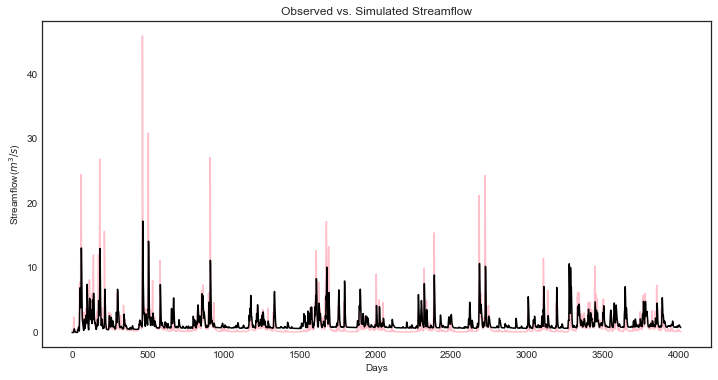

In [5]:
ax = msdbook.plot_observed_vs_simulated_streamflow(df=leaf_data, hymod_dict=model)


<a id='sensitivity'></a> 
# 2- Sensitivity Analysis

Here we use the SALib Python library to explore how different HYMOD input parameters affect model streamflow simulations. For this exercise, we only use Sobol variance-based method. The following commands can be used to import SALib

In [6]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze import delta


### 2-2 Model simulations for sensitivity analysis
We first define the model input and their ranges. 

In [7]:
problem_hymod = {
    'num_vars': 5,
    'names': ['Kq', 'Ks', 'Alp', 'Huz', 'B'],
    'bounds': [[0.1, 1],  # Kq
               [0, 0.1],  # Ks
               [0, 1],    # Alp
               [0.1, 500],  # Huz
               [0, 1.9]]  # B             
}


Now we need to sample and then run the model for each of the sample sets. We will load a sample that has already been created `param_values_hymod` for demonstration purposes.  The actual model simulation takes an extended period, so we also load the simulation data from a previous run. The following demonstrates how to conduct this analysis:
```python

# generate 256 samples. This is an arbitrary number. 
param_values_hymod = saltelli.sample(problem_hymod, 256)

# dictionary to store outputs in
d_outputs = {}

# run simulation for each parameter sample
for i in range(0, len(param_values_hymod)):
    
    # run model for each sensitivity analysis parameter sets
    hymod_output = msdbook.hymod(Nq, 
                                 param_values_hymod[i, 0], 
                                 param_values_hymod[i, 1], 
                                 param_values_hymod[i, 2], 
                                 param_values_hymod[i, 3], 
                                 param_values_hymod[i, 4], 
                                 leaf_data, 
                                 ndays=4015)
    
    # store the simulated total flow discharge
    d_outputs[f"Q{i}"] = hymod_output["Q"]

    
Q_df_bw = pd.DataFrame(d_outputs)
```



In [8]:
# load previously generated parameter values 
param_values_hymod = msdbook.load_hymod_params()

# number of samples
n_samples = len(param_values_hymod)

# load previously generated hymod simulated outputs
Q_df_bw = msdbook.load_hymod_simulation()

# column names of each sample simulation number
sample_column_names = [i for i in Q_df_bw.columns if i[:1] == 'Q']


#### Model Warm-up
A hydrological model such as HYMOD usually includes ordinary differential equations that are sensitive to their initial condition. They also have components in their underlying formulation that have long memory such that prior time steps can affect their current simulations. For example, soil moisture or groundwater can hold water for a long time and therefore they are often considered to exhibit a long memory. This can affect the partitioning of water to runoff and infiltration, while also controlling the generation of base flow. Therefore, it is important to have a reasonable initial value for them. To achieve this, hydrologists usually extend their simulation period and after the simulations, they remove that extended time period that has unreasonable groundwater or surface water values. This time period is called the warm-up time period.

Here we extended our simulation for one year (from 10 years to 11 years) and we removed the first year of simulation, therefore our warm-up period is one year.

In [9]:
# exclude the first year of simulation from the simulations and reset the index
Q_df = Q_df_bw.iloc[365:4015].copy().reset_index(drop=True)

# exclude the first year of the input data and reset the index
leaf_data = leaf_data.iloc[365:4015].copy().reset_index(drop=True)


### 2-3 Visual inspection of the model outputs

Here we create a figure that shows HYMOD streamflow outputs under different sample sets, and compare them with the observed streamflow.

In [10]:
# add date columns to our simulation data frame; for this data our start date is 1/1/2000
date_ts = pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year'] = date_ts.year
Q_df['month'] = date_ts.month
Q_df['day'] = date_ts.day

# aggregate the simulated observed streamflow to monthly mean
df_sim_mth_mean = Q_df.groupby(['year', 'month'])[sample_column_names].mean()

# do the same for the observed data
date_ts = pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year'] = date_ts.year
leaf_data['month'] = date_ts.month
leaf_data['day'] = date_ts.day

# aggregate the daily observed streamflow to monthly mean
df_obs_mth_mean = leaf_data.groupby(['year', 'month']).mean()


<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/3_sensitivity_analysis_the_basics.html#id95">plot_observed_vs_sensitivity_streamflow</a>
</div>

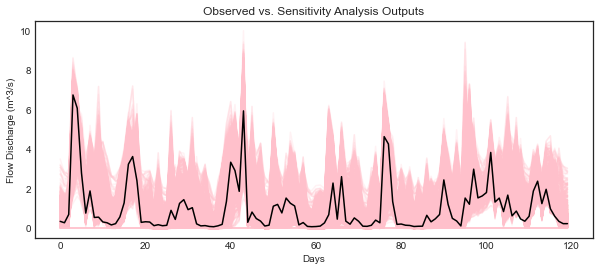

In [11]:
ax = msdbook.plot_observed_vs_sensitivity_streamflow(df_obs=df_obs_mth_mean, 
                                                     df_sim=df_sim_mth_mean)


<a id='sa_metrics'></a> 
# 3- Calculation of Sensitivity Analysis Indices

There are different options to calculate sensitivity indices. The following section aggregates model streamflow outputs and calculates the sensitivity indices.

### 3-1 Aggregated sensitivity analysis indices

This is the simplest way of calculating sensitivity analysis metrics, however, averaging all model response can lead to loss of information that we further explore in the following sections.

In [12]:
# overall aggregated indices
Y = Q_df[sample_column_names].mean().to_numpy()

# Perform analysis
Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)


In [13]:
print('First order indices = ', Si['S1'])


First order indices =  [0.00810372 0.0049972  0.00508833 0.60039872 0.28942293]


In [14]:
Si['S1'].sum()

0.9080109105125653

### 3-2 How do different performance metrics affect the results of our sensitivity analysis?


Streamflow has many different properties. In this section, we discuss how the selection of metrics can lead to fundamentally different sensitivity analysis results. For example, one can only focus on aggregated streamflow metrics such as mean (what has been presented so far), or only on extreme events such as drought or floods.

Here we compare three different metrics:
1- Mean error (ME) 2- Root Mean Square Error (RMSE) 3- Log-Root Mean Square Error (Log(RMSE))

Each of these metrics focuses on a specific attribute of streamflow. For example, RMSE highlights the impacts of extreme flood events, while LOG(RMSE) focuses on model performance during low-flow events.

In [15]:
# calculate error metrics
me = Q_df[sample_column_names].apply(lambda x: (x-leaf_data["Strmflw"]), axis=0)
mse = Q_df[sample_column_names].apply(lambda x: sklearn.metrics.mean_squared_error(x, leaf_data["Strmflw"]), axis=0)
rmse = mse**(1/2)

# add error metrics to a dictionary
d_metrics = {'ME': me.mean().values,
             'RMSE': rmse.values,
             'LOG[RMSE]': np.log10(rmse.values)}

# convert to a dataframe
df_metrics_SA = pd.DataFrame(d_metrics)


In [16]:
# performance analysis
df_metric_sa_result = pd.DataFrame(np.zeros((3, 5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

# conduct sensitivity analysis for each metric
for index, i in enumerate(d_metrics.keys()):
    
    # get the data as a numpy array for the target metric
    Y = d_metrics[i]
    
    # use the metric to conduct SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add the sensitivity indices to the output data frame
    df_metric_sa_result.iloc[index, :] = Si['S1']

# display data frame
df_metric_sa_result


,Kq,Ks,Alp,Huz,B
0,0.008104,0.004997,0.005088,0.600399,0.289423
1,0.106927,0.018771,0.191237,0.300762,0.027852
2,0.134509,0.030292,0.206209,0.296245,0.033833


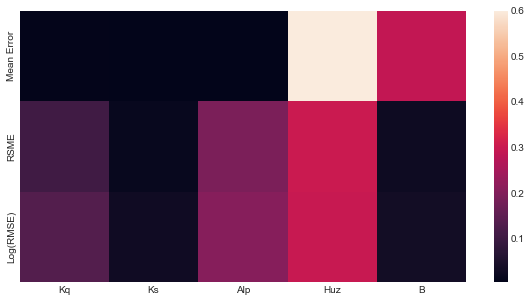

In [17]:
# create seaborn heatmap with required labels
plt.subplots(figsize=(10, 5))

# labels for y-axis
y_axis_labels = ['Mean Error', 'RSME', 'Log(RMSE)']

# plot heatmap
ax = sns.heatmap(df_metric_sa_result, yticklabels=y_axis_labels,  cmap='rocket')


The results indicate that different goodness-of-fit metrics can produce different sensitivity indices. This is because streamflow time series have several dimensions and regimes (e.g., extreme high flow and low flow) and focusing on only one metric will neglect the sensitivity of other dimensions. 

Therefore, we can argue that a single goodness-of-fit measure will never be able to capture the entire response of model to different parametric combinations. For more discussion about this topic readers can refer to [Liu and Sun (2010)](https://www.sciencedirect.com/science/article/pii/S1574954110000580?via%3Dihub) and [Foglia et al., (2009)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR007255).

<a id='TVSA'></a> 
# 4- Time-Varying Sensitivity Analysis

Hydrological processes are often state-dependent, meaning that their responses are affected by the time-varying condition that they are in. For example, rainfall-runoff processes are different in winter and summer. These processes are also different during wet years and dry years.

Hydrological processes are also path-dependent, meaning that previous time-steps on the model affect the present and future simulation of different hydrologic components. To take these properties into account, we can zoom into different time periods to explore how the sensitivity of model parameters evolve in different time steps. This is referred to as time-varying sensitivity analysis.

For more information about time-varying sensitivity analysis, readers can refer to [Herman et al. (2013)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20124) and [Xu et al. (2018)](https://link.springer.com/article/10.1007/s12206-018-0223-8).

### 4-1 Sensitivity analysis indices for each month


In [18]:
# aggregate simulated streamflow data to monthly time series
df_sim_by_mth_mean = Q_df.groupby('month')[sample_column_names].mean()

# aggregate observed streamflow data to monthly time series
df_obs_by_mth_mean = leaf_data.groupby('month').mean()


We can use the following to calculate the SA indices for each month and visualize it. Results are pre-loaded for efficiency.
```python
# set up dataframes to store outputs
df_mth_s1 = pd.DataFrame(np.zeros((12,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
df_mth_delta = df_mth_s1.copy()

# iterate through each month
for i in range(0, 12):
    
    # generate the simulation data
    Y = df_sim_by_mth_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_mth_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_mth_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_mth_s1 = df_mth_s1.values
arr_mth_delta = df_mth_delta.values
```   

#### First-order Indices
The following can be used to visualize the time-varying first-order indices. The first order represents the direct impacts of a specific parameter on model outputs.

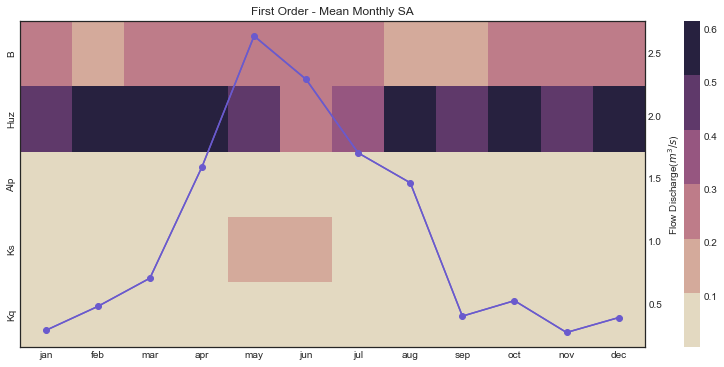

In [19]:
# load previously ran data
arr_mth_delta, arr_mth_s1 = msdbook.load_hymod_monthly_simulations()

# plot figure
ax, ax2 = msdbook.plot_monthly_heatmap(arr_sim=arr_mth_s1.T,
                                       df_obs=df_obs_by_mth_mean,
                                       title='First Order - Mean Monthly SA')


This figure demonstrates the first order sensitivity indices when the streamflow data are aggregated by month. The purple line represents the observed monthly discharge. The figure indicates that the first order indices are highest for B and Huz across all months and lowest for Alp, Ks, and Kq. 

#### Total-order indices
We can also focus on the total order sensitivity index that includes first-order SA indices and interactions between parameters

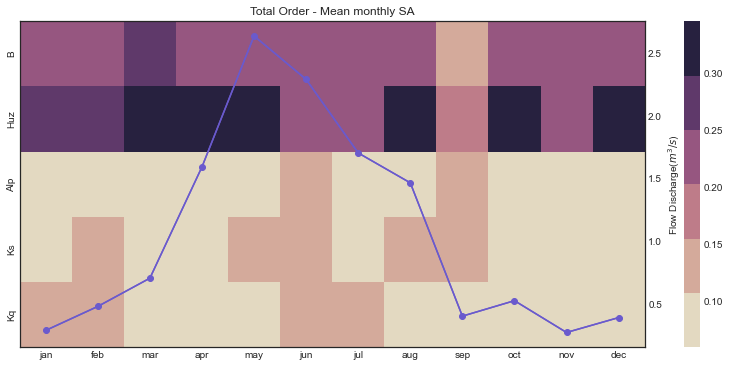

In [20]:
# plot figure
ax, ax2 = msdbook.plot_monthly_heatmap(arr_sim=arr_mth_delta.T,
                                       df_obs=df_obs_by_mth_mean,
                                       title='Total Order - Mean monthly SA')


Notably, the total order sensitivity results are different than the first order sensitivity results, which indicates that interactions between the parameters (particularly in regards to $Kq$, $Ks$, and $Alp$) contribute to variance in the HYMOD output. 

### 4-2 Annual sensitivity analysis indices

In [21]:
# group by year and get mean
df_sim_by_yr_mean = Q_df.groupby(['year'])[sample_column_names].mean()

# group input data and get mean
df_obs_by_yr_mean = leaf_data.groupby(['year']).mean()


We can also calculate the sensitivity analysis indices for each individual year. This will allow us to understand if model control changes during different years. The following code first aggregates the outputs to annual time steps, and then calculates the SA indices.
```python
# set up dataframes to store outputs
df_yr_s1 = pd.DataFrame(np.zeros((10, 5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
df_yr_delta = df_yr_s1.copy()

# iterate through each year
for i in range(0, 10):
    
    # generate the simulation data
    Y = df_sim_by_yr_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_yr_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_yr_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_yr_s1 = df_mth_s1.values
arr_yr_delta = df_mth_delta.values
```

#### First-order indices

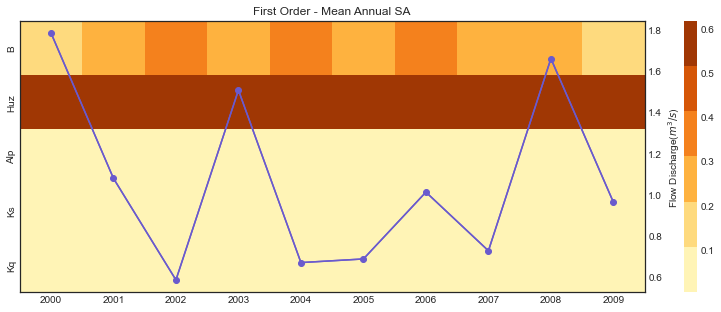

In [22]:
# load previously ran data
arr_yr_delta, arr_yr_s1 = msdbook.load_hymod_annual_simulations()

# plot figure
ax, ax2 = msdbook.plot_annual_heatmap(arr_sim=arr_yr_s1.T, 
                                      df_obs=df_obs_by_yr_mean,
                                      title='First Order - Mean Annual SA')


The first order sensitivities at the annual scale are not unlike the first order monthly sensitivities. Once again, sensitivities vary across year and Huz and B are the most consequential parameters. 

#### Total-order indices

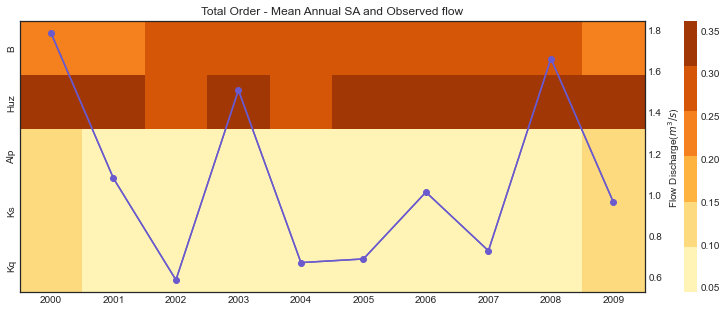

In [23]:
# plot figure
ax, ax2 = msdbook.plot_annual_heatmap(arr_sim=arr_yr_delta.T, 
                                      df_obs=df_obs_by_yr_mean,
                                      title='Total Order - Mean Annual SA and Observed flow')


Our results indicate that sensitivity analysis indices vary in different years and now that interactions are included, the Kq, Ks, and Alp variables impact the sensitivity of the streamflow output. 

### 4-3 Monthly time-varying sensitivity analysis

Although time-varying sensitivity analysis at average monthly and average annual temporal resolutions is informative, TVSA is susceptible to the aggregation issue that we discussed earlier in section 3-2. To avoid that we can further discretize our time domain to zoom into individual months. This will provide us with even more information about model behavior and the sensitivity of different parameters in different states of the system. The block of code demonstrates how to implement the monthly TVSA.
```python
# set up dataframes to store outputs
df_vary_s1 = pd.DataFrame(np.zeros((df_obs_mth_mean.shape[0], 5)), 
                          columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

df_vary_delta = df_vary_s1.copy()

# iterate through each month
for i in range(0, df_obs_mth_mean.shape[0]):
    
    # generate the simulation data
    Y = df_sim_mth_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_vary_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_vary_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_vary_s1 = df_vary_s1.values
arr_vary_delta = df_vary_delta.values
```

#### First-order indices

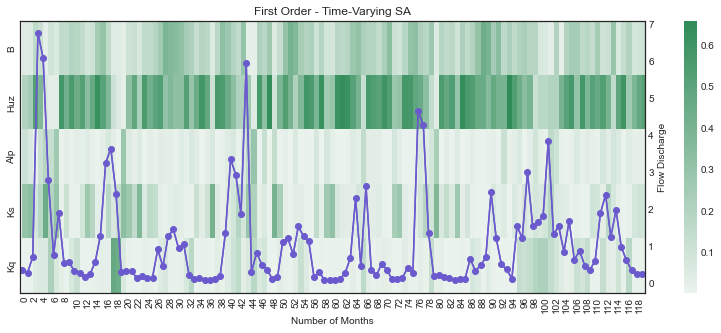

In [25]:
# load in previously ran data
arr_vary_delta, arr_vary_s1 = msdbook.load_hymod_varying_simulations()

# plot figure
ax, ax2 = msdbook.plot_varying_heatmap(arr_sim=arr_vary_s1.T, 
                                      df_obs=df_obs_mth_mean,
                                      title='First Order - Time-Varying SA')


Compared to the TVSA when streamflow was aggregated, this figure suggests that Kq is indeed a relevant parameter for influencing streamflow output when individual months are considered.   

#### Total order - time varying sensitivity analysis

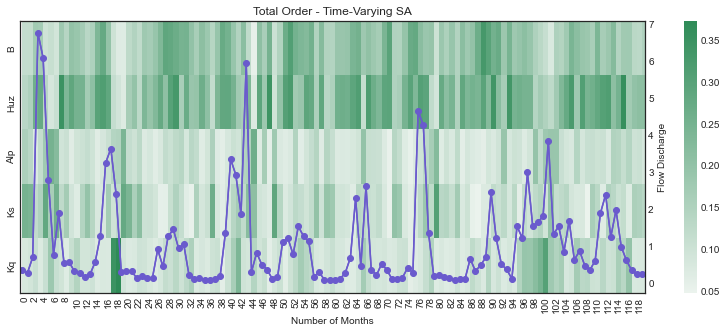

In [26]:
# plot figure
ax, ax2 = msdbook.plot_varying_heatmap(arr_sim=arr_vary_delta.T, 
                                      df_obs=df_obs_mth_mean,
                                      title='Total Order - Time-Varying SA')


As above, the total order sensitivities further indicate the importance of Kq that is not apparent if aggregation is utilized. 

# Ensemble-based Parametric Uncertainty

<a id='GLUE'></a> 
# 5- Generalized Likelihood Uncertainty Estimation (GLUE)

The Generalized Likelihood Uncertainty Estimation (GLUE) is an uncertainty analysis algorithm that has been widely used in hydrologic studies. The main argument behind GLUE is rooted in model calibration and the concept of equifinality. Calibration of complex simulation tools such as hydrological models often produces more than one optimal or near-optimal solutions and these solutions have equivalent chances to be chosen [(Beven and Freer, 2001)](https://www.sciencedirect.com/science/article/abs/pii/S0022169401004218). This situation is called equifinality. GLUE provides a methodological framework to handle this problem and consider more than one optimal calibration set.

GLUE usually includes the following steps [(Beven and Bineley, 1992)](https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.3360060305?casa_token=o2ooj-6wmC4AAAAA:WpVg1ysAtD59QbSpdHKX6IOjfjeHsOfqxCC6RvoXgiW6bDBRGNfdkOv-AH6h3WhT7-2mD4xmwzMi):

1) Definition of a likelihood function  <br>
2) Definition of ranges of parameters <br>
3) Sensitivity analysis <br>
4) Calculating likelihood (goodness-of-fit) values for each model simulation <br>
5) Define a threshold and find sample sets that have higher likelihoods than the threshold <br>
6) Visualize the sample sets <br>

### 5-1 Calculation of GLUE metrics

#### Likelihood calculation (inverse error variance)
There are various likelihood metrics that have been used in previous studies that use GLUE. A widely used example is inverse error variance (IEV; [Vrugt et al. 2009](https://link.springer.com/article/10.1007/s00477-008-0274-y) and [Beven and Bineley, 1992](https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.3360060305?casa_token=o2ooj-6wmC4AAAAA:WpVg1ysAtD59QbSpdHKX6IOjfjeHsOfqxCC6RvoXgiW6bDBRGNfdkOv-AH6h3WhT7-2mD4xmwzMi)): 

$$ IEV = {({\sigma_{e}}^{2})}^{-T} = ({{\frac{SSR}{n-2}}})^{-T} $$

The other metric that can be used as an estimation of likelihood is normalized inverse error variance:
$$ NIEV = \frac{IEV}{\sum_{i=1}^{n} IEV(i)} $$

where *SSR* is the sum of squared residuals; $n$ is the number of samples; and $T$ is an arbitrary coefficient. Low $T$ values lead to equal weights placed on each sample set while higher $T$ values concentrate on the best parameter sets.

In [ ]:
# From Vrugt et al (2008) : inverse error variance

# T=0 means that we only select the best simulated values that are closer to the observed values 
#  T=infinity means that all sample sets have the same probability
T= 0.70 

some_shape = df_metrics_SA.loc[:,"SSR"].shape[0]-2

# calculate metrics from Beven and Binley, 1992
df_metrics_SA["SSR"] = df_metrics_SA["RMSE"]**2 * 3650
df_metrics_SA["InverseErrorVariance"] = (df_metrics_SA["SSR"] / some_shape)**(-T) 
df_metrics_SA["Normalized_IEV"] = df_metrics_SA["InverseErrorVariance"] / df_metrics_SA["InverseErrorVariance"].sum()

# convert array to dataframe
param_values_hymod_df = pd.DataFrame(param_values_hymod, columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

# combine the metrics and param values dataframes and calculate combined metrics
concat_df = pd.concat([df_metrics_SA, param_values_hymod_df], axis=1)
concat_df["Ks_rescale"] = concat_df["Ks"] / 0.1
concat_df["Huz_rescale"] = concat_df["Huz"] / 500
concat_df["B_rescale"] = concat_df["B"] / 2


In [30]:
df_metrics_SA.head()

,ME,RMSE,LOG[RMSE],SSR,InverseErrorVariance,Normalized_IEV
0,-1.067901,2.601592,0.415239,24704.2204,0.259599,0.000185
1,-1.067901,2.601592,0.415239,24704.2204,0.259599,0.000185
2,-1.067901,2.601592,0.415239,24704.2204,0.259599,0.000185
3,-1.067901,2.601592,0.415239,24704.2204,0.259599,0.000185
4,-1.067901,2.601592,0.415239,24704.2204,0.259599,0.000185


#### Distribution of likelihoods (inverse error variance) values

/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='InverseErrorVariance', ylabel='Density'>

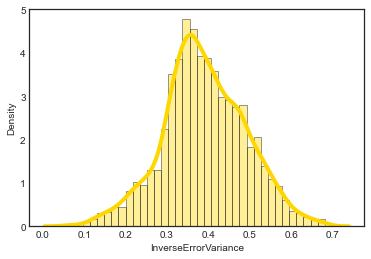

In [34]:
# Density Plot and Histogram of all arrival delays
sns.distplot(df_metrics_SA["InverseErrorVariance"], 
             hist=True, 
             kde=True, 
             bins=int(180/5), 
             color = 'gold', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


#### Distribution of normalized inverse error variance values

/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Normalized_IEV', ylabel='Density'>

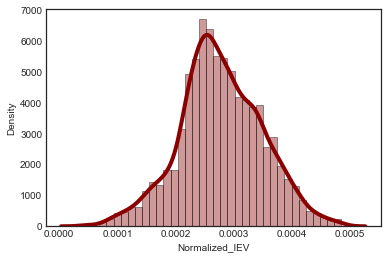

In [35]:
# density Plot and Histogram of all arrival delays
sns.distplot(df_metrics_SA["Normalized_IEV"], 
             hist=True, 
             kde=True, 
             bins=int(180/5), 
             color='darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


#### Selection of important sample sets and setting a threshold for physical/non-physical sample sets

In [36]:
# selection of important sample sets
percentile = 95

threshold = np.percentile(concat_df["InverseErrorVariance"], percentile)
print(f"Threshold using the {percentile} percentile:  {threshold}")

# select values greater than the threshold
selected_values = concat_df[concat_df["InverseErrorVariance"] > threshold]


threshold == 0.5564905750340239


### 5-2 Visual inspection of GLUE results

In [37]:
# format the data frame so that it may be used for plotting
to_plot = pd.melt(selected_values,
                  id_vars=['ME'], 
                  value_vars=['Kq', 'Ks_rescale', 'Alp', 'Huz_rescale', 'B_rescale']) 


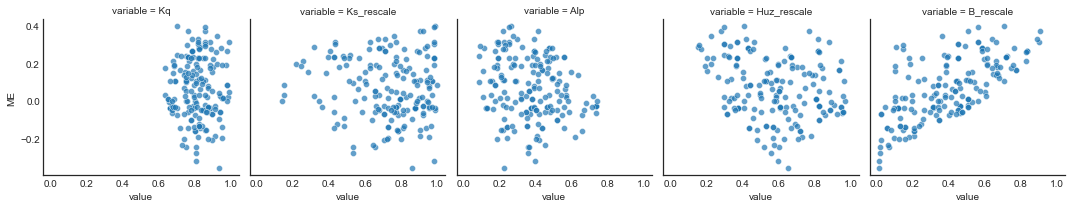

In [38]:
# build a plot with multiple panels of scatter plots where ME is the target metric
g = sns.FacetGrid(to_plot, col="variable")

# map the scatter plots to the facet grid panels
g.map(sns.scatterplot, "value", "ME",  alpha=0.7)

g.add_legend()


/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function 

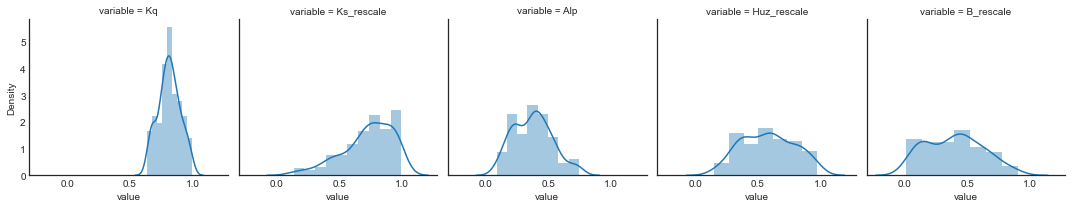

In [39]:
# build a plot with multiple panels of histogram plots where ME is the target metric
g_2 = sns.FacetGrid(to_plot, col="variable")

# map the plots to the facet grid panels
g_2.map(sns.distplot, "value")


g_2.add_legend()


### 5-3 Comment on the GLUE results

Our results suggest that it is challenging to find an clear and interpretable relationship between different selected near-optimal sample sets at least by visual inspection. The main reason for this is that HYMOD includes a complex non-linear system of equations that is also affected by initial conditions and complexity of its input time series. Therefore, it does not have a clear control.

Glue has been widely used in hydrology, the original paper has more than 5000 citations. However, the likelihood measure that GLUE uses is not actually a statistically sound likelihood metric and is in fact a goodness-of-fit measure. Therefore, it might not produce valid insights when dealing with situations of non-normality, heteroscedasticity, and serial correlation. For more on these issues reader can refer to [Stedinger et al., (2008)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR006822%4010.1002/%28ISSN%291944-7973.ASSESS1), [Mantovan and Todini, (2006)](https://www.sciencedirect.com/science/article/pii/S0022169406002162?casa_token=Ml8dhBrO5PkAAAAA:Ake1YuQo0OxK6BaaG-8wIdHa_kd4cuUpm7WiHBFur-G_DlRze6Z0_GkwWH3qHDLKwbJDO9mN), and [Beven And Binley, (2014)](https://onlinelibrary.wiley.com/doi/full/10.1002/hyp.10082).

<a id='precalibration'></a> 
# 6- Pre-Calibration

Pre-calibration [(Edwards et al, 2010)](https://link.springer.com/article/10.1007/s00382-010-0921-0) is a simplified method to deal with uncertainty in complex environmental models. Pre-calibration can also be thought of as another method that tackles the shortcomings and conceptual challenges involved in calibration of complex environmental models. In pre-calibration instead of finding the best solutions, we focus on finding the sample sets that create outputs that are against the common understanding of the system. These parameter sets are called non-physical parameter sets. In other words, the probability that these parameters are among the best sample sets is zero or near zero and can be neglected in practice.

 
Pre-calibration can include the following steps: <br>
1) Sensitivity analysis <br>
2) Definition of non-physical boundaries <br>
3) Delineating regions in the output space which are non-physical (Implausible) <br>
4) Map non-physical sets back to input space <br>
5) Interpret the non-physical sample sets <br>

### 6-1 Pre-calibration calculations

#### Distribution of mean error, RMSE, and Log[RMSE] under different sample sets

/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function 

Text(0.5, 1.0, 'Distribution of LOG[RMSE] in Different Sample Sets')

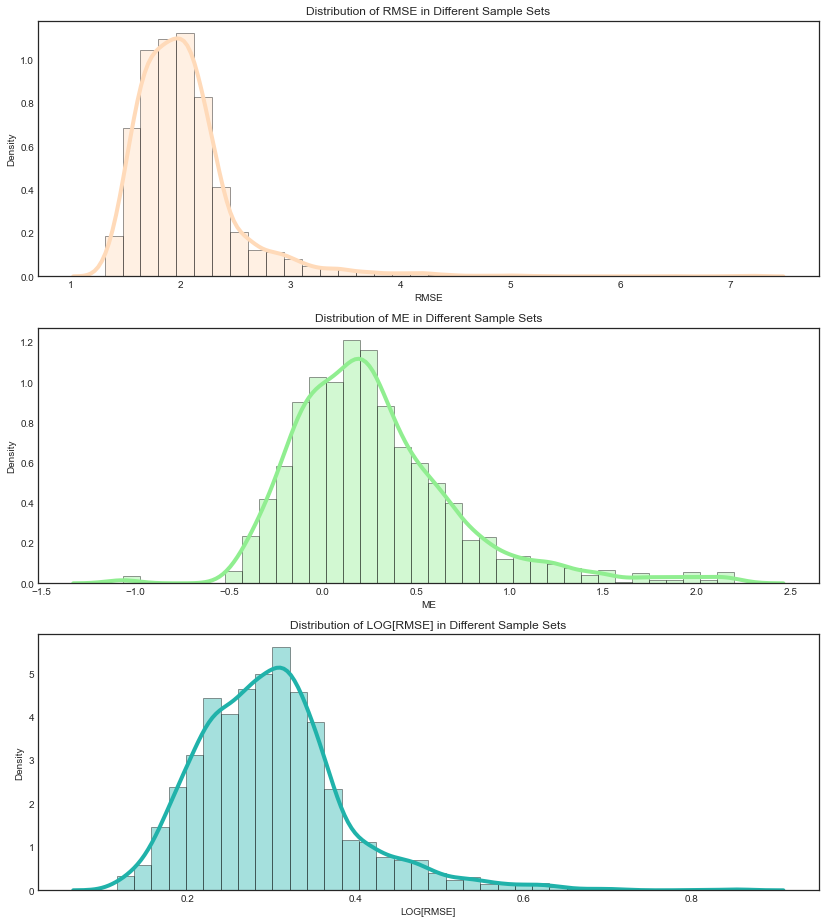

In [40]:
# set up figure and axis objects
fig, axs = plt.subplots(nrows=3, figsize=(14,16))

# axis 1 (first row in figure)
sns.distplot(concat_df["RMSE"], 
             ax=axs[0], 
             hist=True, 
             kde=True, 
             bins=int(180/5), 
             color='peachpuff', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of RMSE in Different Sample Sets')

# axis 2 (second row in figure)
sns.distplot(concat_df["ME"],
             ax=axs[1], 
             hist=True, 
             kde=True, 
             bins=int(180/5), 
             color='lightgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of ME in Different Sample Sets')

# axis 3 (third row in figure)
sns.distplot(concat_df["LOG[RMSE]"],
             ax=axs[2], 
             hist=True, 
             kde=True, 
             bins=int(180/5), 
             color = 'lightseagreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title('Distribution of LOG[RMSE] in Different Sample Sets')


#### Setting a threshold for physical/non-physical sample sets

In [41]:
# selection of physical/non-physical sample sets
percentile = 95

threshold_precal = np.percentile(concat_df["RMSE"], percentile)
print(f"Threshold using the {percentile} percentile:  {threshold}")

# select values greater than the threshold
selected_values_precal = concat_df[concat_df["RMSE"] > threshold_precal]


threshold == 2.9248597330935033


#### Visual inspection of non-physical sample sets

In [42]:
# format the data frame so that it may be used for plotting
to_plot_precal = pd.melt(selected_values_precal, 
                         id_vars=['ME'], 
                         value_vars=['Kq', 'Ks_rescale', 'Alp', 'Huz_rescale', 'B_rescale']) 


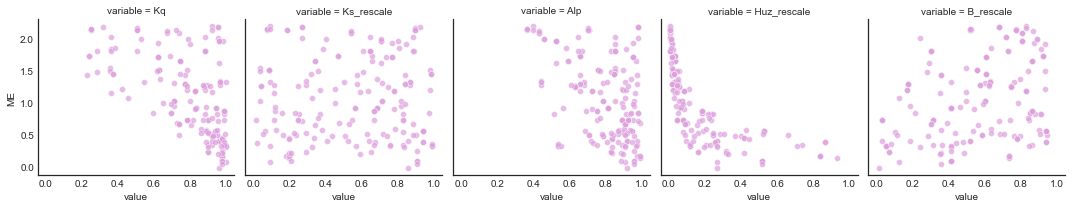

In [43]:
# build a plot with multiple panels of scatter plots where ME is the target metric
g = sns.FacetGrid(to_plot_precal, col="variable")

# map the scatter plots to the facet grid panels
g.map(sns.scatterplot, "value", "ME",  alpha=0.7, color='plum')

g.add_legend()


/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/d3y010/.pyenv/versions/py3.9.4_msd/lib/python3.9/site-packages/seaborn-0.11.2rc0-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function 

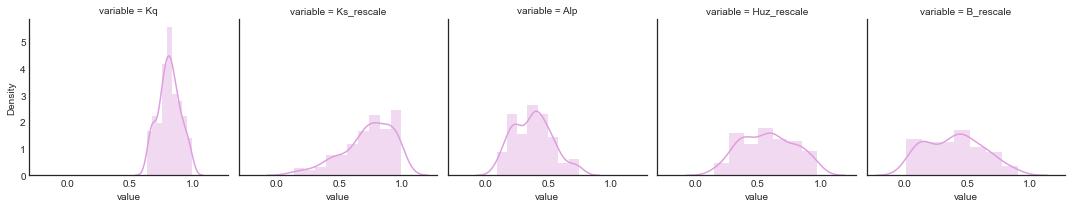

In [44]:
# build a plot with multiple panels of histogram plots where ME is the target metric
g_2 = sns.FacetGrid(to_plot_precal, col="variable")

# map the plots to the facet grid panels
g_2.map(sns.distplot, "value", color='plum')

g_2.add_legend()


The following figure shows the flow discharge provided by the ensemble of parameters sets from Pre-Calibration versus the observed flow data. 

In [ ]:
# mean monthly indices 
Q_df_precal = pd.concat([Q_df.iloc[:, selected_values_precal.index], 
                         Q_df[['month' , 'year']]], 
                        axis=1) 

# calculate year, month mean
df_precal_mth_mean = Q_df_precal.groupby(['year', 'month'])[sample_column_names].mean()


fig_2_3, ax_fig_2_3=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(df_precal_mth_mean)), df_precal_mth_mean.iloc[:,2],  color="lightgreen", alpha=0.2)
ax_fig_2_3.set_xlabel('Days')
ax_fig_2_3.set_ylabel('Flow Discharge')

for i_ps in range(0, df_precal_mth_mean.shape[1]):
    plt.plot(range(0, df_precal_mth_mean.shape[0]), df_precal_mth_mean.iloc[:,i_ps],  color="lightgreen", alpha=0.2)


plt.plot(range(0, len(df_precal_mth_mean)), df_obs_mth_mean.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')
custom_lines = [Line2D([0], [0],  color="lightgreen", lw=4),
                Line2D([0], [0], color="black", lw=4)]
plt.legend(custom_lines, ['Pre-Calibration', 'Observed',])
plt.show()


NameError: name 'agg_m_Q_beh_df' is not defined

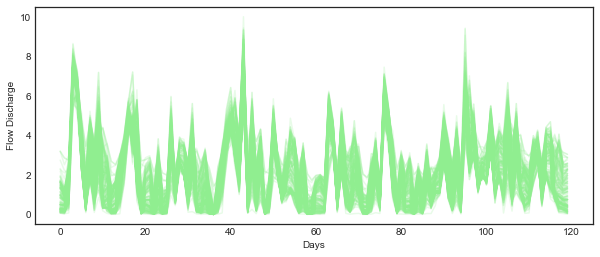

In [45]:
# mean monthly indices 
date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_precal=pd.concat([Q_df.iloc[:,selected_values_precal.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_precal_df=Q_df_precal.groupby(['year', 'month'])
agg_m_precal_df=m_Q_precal_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_3, ax_fig_2_3=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_precal_df)), agg_m_precal_df.iloc[:,2],  color="lightgreen", alpha=0.2)
ax_fig_2_3.set_xlabel('Days')
ax_fig_2_3.set_ylabel('Flow Discharge')

for i_ps in range(0, agg_m_precal_df.shape[1]):
    plt.plot(range(0, agg_m_precal_df.shape[0]), agg_m_precal_df.iloc[:,i_ps],  color="lightgreen", alpha=0.2)


plt.plot(range(0, len(agg_m_precal_df)), agg_m_leaf_data.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs')
custom_lines = [Line2D([0], [0],  color="lightgreen", lw=4),
                Line2D([0], [0], color="black", lw=4)]
plt.legend(custom_lines, ['Pre-Calibration', 'Observed',])
plt.show()


The following figure shows the flow discharge provided by the ensemble of parameters sets from both pre-calibration and GLUE and how these flows compare to the observed flow data. 

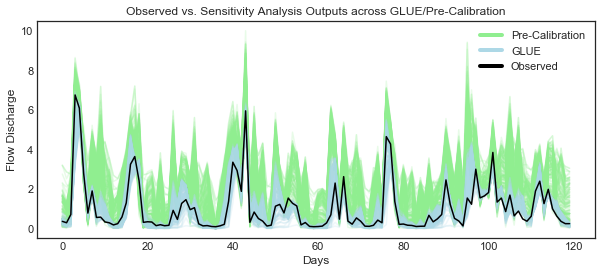

In [49]:
# mean monthly indices 
from matplotlib.lines import Line2D
date_ts=pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year']=date_ts.year
Q_df['month']=date_ts.month
Q_df['day']=date_ts.day

Q_df_precal=pd.concat([Q_df.iloc[:,selected_values_precal.index], Q_df.loc[:,['month' , 'year']]], axis=1) 

m_Q_precal_df=Q_df_precal.groupby(['year', 'month'])
agg_m_precal_df=m_Q_precal_df.aggregate(np.mean)

date_ts=pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year']=date_ts.year
leaf_data['month']=date_ts.month
leaf_data['day']=date_ts.day

m_leaf_data=leaf_data.groupby(['year', 'month'])
agg_m_leaf_data=m_leaf_data.aggregate(np.mean)


fig_2_3_2, ax_fig_2_3_2=plt.subplots(figsize=[10,4])
plt.plot(range(0, len(agg_m_precal_df)), agg_m_precal_df.iloc[:,2],  color="lightgreen", alpha=0.2)
ax_fig_2_3_2.set_xlabel('Days')
ax_fig_2_3_2.set_ylabel('Flow Discharge')
#ax_fig_2.set_facecolor('white')

# This for loop prints all simulated streamflow cases under different sample sets 

for i_ps in range(0, agg_m_precal_df.shape[1]):
    plt.plot(range(0, agg_m_precal_df.shape[0]), agg_m_precal_df.iloc[:,i_ps],  color="lightgreen", alpha=0.2)

for i_ps in range(0, agg_m_Q_beh_df.shape[1]):
    plt.plot(range(0, agg_m_Q_beh_df.shape[0]), agg_m_Q_beh_df.iloc[:,i_ps],  color="lightblue", alpha=0.2)


plt.plot(range(0, len(agg_m_precal_df)), df_obs_mth_mean.iloc[0:len(agg_m_Q_beh_df),2],  color="black")
plt.title('Observed vs. Sensitivity Analysis Outputs across GLUE/Pre-Calibration')
custom_lines = [Line2D([0], [0],  color="lightgreen", lw=4),
                Line2D([0], [0], color="lightblue", lw=4),
                Line2D([0], [0], color="black", lw=4),]
plt.legend(custom_lines, ['Pre-Calibration', 'GLUE', 'Observed'])
plt.show()

### 6-2 Comments on Pre-Calibration

Although Pre-calibrations provides a helpful and relatively simple alternative for statistical inferences, it has some disadvantages. For example, it is often subjective and challenging to provide a threshold for non-physical model outputs. Moreover, as discussed earlier different goodness-of-fit metrics can produce distinct physical and non-physical sample sets. 

More information about pre-calibration can be found in [(Edwards et al., 2010)](https://link.springer.com/article/10.1007/s00382-010-0921-0), and  [Ruckert et al., (2017)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0170052).